In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import math
import os
import sys
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import redis
from jfi import jaxm
from line_profiler import LineProfiler

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from pmpc import solve as pmpc_solve

from mpcjax import solve
from mpcjax.jax_solver import _build_problems
from mpcjax.problem_struct import Problem
from tests.dynamics import f_fx_fu_fn

In [3]:
{k: v for (k, v) in os.environ.items() if k.startswith("XLA")}

{'XLA_PYTHON_CLIENT_ALLOCATOR': 'platform',
 'XLA_PYTHON_CLIENT_PREALLOCATE': 'False'}

In [8]:
N, xdim, udim = 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1e0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

problem = dict(
    f_fx_fu_fn=f_fx_fu_fn,
    Q=Q,
    R=R,
    x0=x0,
    X_ref=X_ref,
    U_ref=U_ref,
    X_prev=X_prev,
    U_prev=U_prev,
    u_l=u_l,
    u_u=u_u,
    solver_settings=dict(smooth_alpha=1e2, solver="sqp", linesearch="scan", maxls=20),
    reg_x=1e0,
    reg_u=1e-1,
    max_it=50,
    res_tol=1e-12,
    verbose=True,
    slew_rate=1e0,
    P=1.0 * jaxm.ones((N,)),
    dtype=np.float32,
    device="cpu",
)

# solve

In [10]:
X1, U1, _ = solve(**problem, direct_solve=True)
X2, U2, _ = solve(**problem, direct_solve=False)
X3, U3, _ = pmpc_solve(
    **dict(
        problem,
        solver_settings=dict(problem["solver_settings"], solver="ecos"),
    )
)
print(f"dtype = {X1.dtype}, device = {X1.device()}")

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  2.099e-02 |  3.628e-01 |  2.017e+00 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0002 |  3.863e-02 |  1.068e-01 |  9.975e-02 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0003 |  5.384e-02 |  1.058e-01 |  2.726e-02 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0004 |  6.770e-02 |  1.057e-01 |  1.378e-02 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0005 |  8.551e-02 |  1.057e-01 |  7.201e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0006 |  1.029e-01 |  1.057e-01 |  3.820e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0007 |  1.215e-01 |  1.057e-01 |  2.084e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0008 |  1.339e-01 |  1.057e-01 |  1.163e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0009 |  1.461e-01 |  1.057e-01 |  1.272e-03 |  1.0e+00 |  1.0e-01 |  1.0e+02 |
| 0010 |  1.584e-01 |  1.057

In [11]:
print(f"{jaxm.max(jaxm.abs(U1 - U2)):.4e}")
print(f"{jaxm.max(jaxm.abs(U1 - U3)):.4e}")
print(f"{jaxm.max(jaxm.abs(X1 - X2)):.4e}")
print(f"{jaxm.max(jaxm.abs(X1 - X3)):.4e}")
print()
print(f"{jaxm.norm(U1 - U2):.4e}")
print(f"{jaxm.norm(U1 - U3):.4e}")
print(f"{jaxm.norm(X1 - X2):.4e}")
print(f"{jaxm.norm(X1 - X3):.4e}")

3.1672e-04
7.2353e-03
6.3165e-04
7.2264e-03

8.5562e-04
1.6892e-02
2.4054e-03
2.0438e-02


# Plot the results for a qualitative check

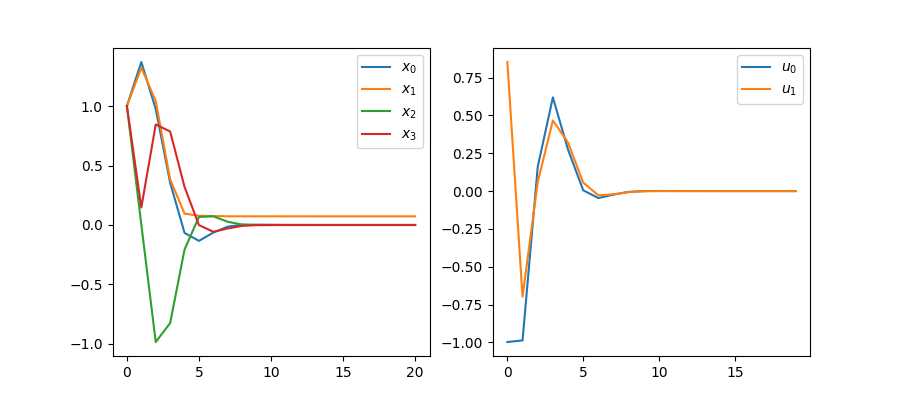

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
for i in range(X.shape[-1]):
    ax[0].plot(X[:, i], label=f"$x_{i}$")
ax[0].legend()
for i in range(U.shape[-1]):
    ax[1].plot(U[:, i], label=f"$u_{i}$")
ax[1].legend()

# Check optimality conditions

In [71]:
def solve(H, g, dtype=jaxm.float64):
    return jaxm.linalg.solve(*jaxm.to((H, g), dtype=dtype))

def solve_precond(H, g, L, R, dtype=jaxm.float64):
    H, g, L, r = jaxm.to((H, g, L, R), dtype=dtype)
    H = jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)
    g = g / L
    return jaxm.linalg.solve(H, g) / R

def cond(H):
    return jaxm.linalg.cond(jaxm.to(H, device="cpu", dtype=jaxm.float64))

In [74]:
H = jaxm.randn((100, 100))
g = jaxm.randn((100,))
Q = jaxm.linalg.qr(H)[0]
H = Q @ jaxm.diag(jaxm.logspace(-9, 0, Q.shape[-1])) @ Q.T

ys = solve(H, g)
L, R = jaxm.linalg.norm(H, axis=-1), jaxm.linalg.norm(H, axis=-2)
L2, R2 = jaxm.linalg.norm(H, axis=-2), jaxm.linalg.norm(H, axis=-1)

print(f"{jaxm.norm(ys - solve(H, g, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, R2, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, L2, jaxm.ones(R.shape), jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R, jaxm.float32)) / jaxm.norm(ys):.4e}")
print(f"{jaxm.norm(ys - solve_precond(H, g, jaxm.ones(R.shape), R2, jaxm.float32)) / jaxm.norm(ys):.4e}")

4.9932e+00
1.9298e+01
1.9298e+01
1.9298e+01
1.9298e+01
8.3982e-01
8.3982e-01


In [70]:
print(f"{cond(jaxm.diag(1.0 / L) @ H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(jaxm.diag(1.0 / L) @ H):.4e}")
print(f"{cond(jaxm.diag(1.0 / L2) @ H):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R)):.4e}")
print(f"{cond(H @ jaxm.diag(1.0 / R2)):.4e}")
print(f"{cond(H):.4e}")

8.6951e+04
8.6951e+04
8.8527e+04
8.8527e+04
8.8527e+04
8.8527e+04
1.0000e+05
